# PsychohistoryML: Violence & Atrocity Analysis (Notebook 08)

**Objective**: Analyze the relationship between state violence, atrocities, and civilizational stability using variables from TSDat123 that were not covered in NB05 (warfare technology).

## Background

NB05 analyzed **warfare technology** (weapons, armor, fortifications) and found it significantly improves collapse prediction. However, TSDat123 contains a separate class of variables measuring **violence intensity and atrocities**:

- Internal conflict (civil wars, uprisings, military revolts)
- External conflict types (ethnic, religious, frontier wars)
- Atrocities (torture, rape, enslavement, genocide, mass killings)
- Archaeological evidence of violence

**Research Questions**:
1. Do atrocity variables predict civilizational duration independently of warfare technology?
2. Does internal vs. external conflict have different effects on stability?
3. Is there a "violence threshold" beyond which instability increases?
4. How do violence patterns vary across eras?

**Note**: Human Sacrifice IS available in AggrSCWarAgriRelig sheet (HS column).

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, r2_score, classification_report

# Setup
sns.set_style("whitegrid")
Path("figures").mkdir(exist_ok=True)

print("Setup complete")

Setup complete


## 1. Load TSDat123 Violence Variables

Extract violence/atrocity variables that weren't used in NB05.

In [50]:
# Load the raw Equinox data
equinox_path = "../data/Equinox_on_GitHub_June9_2022.xlsx"

# Load TSDat123 sheet (contains time-series conflict data)
try:
    tsdat = pd.read_excel(equinox_path, sheet_name='TSDat123')
    print(f"Loaded TSDat123: {tsdat.shape}")
    print(f"\nColumns: {list(tsdat.columns)[:30]}...")  # First 30 columns
except Exception as e:
    print(f"Error loading TSDat123: {e}")
    # Fallback: list available sheets
    xl = pd.ExcelFile(equinox_path)
    print(f"Available sheets: {xl.sheet_names}")

Loaded TSDat123: (1494, 168)

Columns: ['NGA', 'PolID', 'Time', 'PropCoded', 'PolPop', 'PolTerr', 'CapPop', 'AdmLev', 'MilLev', 'ReligLev', 'SettlHier', 'ProfOfficer', 'ProfSoldier', 'ProfPriest', 'FullTBur', 'ExamSyst', 'MeritProm', 'GovtBldg', 'Court', 'LegCode', 'Judge', 'Lawyer', 'Irrigation', 'WaterSuppl', 'Market', 'FoodStor', 'Road', 'Bridge', 'Canal', 'Port']...


In [51]:
# Define violence/atrocity variable groups (ACTUAL TSDat123 column names)

INTERNAL_CONFLICT_VARS = ['InternalW', 'IntraElitW', 'PopUprising', 'MilRevolt', 'SepRebellion']

EXTERNAL_CONFLICT_VARS = ['ExternalW', 'EthnicW', 'DiffReligW', 'ReligTribW', 'CivBarbW', 'StepFrontW', 'AgriFrontW']

ATROCITY_VARS = ['Annexation', 'Looting', 'Sack', 'Rape', 'Enslavement', 'Imprisonment',
                 'Destruction', 'Torture', 'Mutilation', 'TargMassacre', 'GenMassacre', 
                 'Extermination', 'Ethnocide']

ARCHAEOLOGICAL_VARS = ['SkeletViol', 'MassBurial', 'SettlDestr', 'PictorialW']

ALL_VIOLENCE_VARS = INTERNAL_CONFLICT_VARS + EXTERNAL_CONFLICT_VARS + ATROCITY_VARS + ARCHAEOLOGICAL_VARS

print(f"Violence variables: {len(ALL_VIOLENCE_VARS)}")
print(f"  Internal conflict: {len(INTERNAL_CONFLICT_VARS)}")
print(f"  External conflict: {len(EXTERNAL_CONFLICT_VARS)}")
print(f"  Atrocities: {len(ATROCITY_VARS)}")
print(f"  Archaeological: {len(ARCHAEOLOGICAL_VARS)}")

Violence variables: 29
  Internal conflict: 5
  External conflict: 7
  Atrocities: 13
  Archaeological: 4


In [52]:
# Check coverage for all violence variables
print("=== VIOLENCE VARIABLE COVERAGE ===\n")

coverage_data = []
for col in ALL_VIOLENCE_VARS:
    if col in tsdat.columns:
        valid = (tsdat[col] != -999).sum()
        coverage = valid / len(tsdat) * 100
        mean_val = tsdat[tsdat[col] != -999][col].mean()
        coverage_data.append({'Variable': col, 'Valid': valid, 'Coverage': coverage, 'Mean': mean_val})
    else:
        print(f"WARNING: {col} not found!")

coverage_df = pd.DataFrame(coverage_data)
coverage_df = coverage_df.sort_values('Coverage', ascending=False)
print(coverage_df.to_string(index=False))

print(f"\n=== SUMMARY ===")
print(f"Variables with >50% coverage: {(coverage_df['Coverage'] > 50).sum()}")
print(f"Variables with >40% coverage: {(coverage_df['Coverage'] > 40).sum()}")

=== VIOLENCE VARIABLE COVERAGE ===

     Variable  Valid  Coverage     Mean
    ExternalW    899 60.174029 0.763404
   DiffReligW    892 59.705489 0.231839
   ReligTribW    771 51.606426 0.170169
    InternalW    762 51.004016 0.719291
      EthnicW    711 47.590361 0.707173
   StepFrontW    711 47.590361 0.356259
   AgriFrontW    706 47.255689 0.055666
   Annexation    667 44.645248 0.692954
   IntraElitW    657 43.975904 0.658904
 SepRebellion    621 41.566265 0.513366
      Looting    600 40.160643 0.676000
  Destruction    594 39.759036 0.670034
   SkeletViol    582 38.955823 0.672165
  PopUprising    561 37.550201 0.542246
  Enslavement    544 36.412316 0.619118
   PictorialW    544 36.412316 0.423529
 TargMassacre    543 36.345382 0.614365
    MilRevolt    538 36.010710 0.405948
    Ethnocide    500 33.467202 0.354800
         Sack    497 33.266399 0.612475
 Imprisonment    484 32.396252 0.589463
   SettlDestr    469 31.392236 0.411940
Extermination    454 30.388220 0.310352
  Ge

## 2. Data Preparation

Merge violence variables with the existing modeling dataset from NB07.

In [53]:
# Load the modeling dataset from NB07 (has duration, era, existing features)
modeling_df = pd.read_csv('models/equinox_with_religion.csv', index_col=0)
print(f"Modeling dataset: {modeling_df.shape}")
print(f"Polities: {len(modeling_df)}")

Modeling dataset: (256, 47)
Polities: 256


In [54]:
# Also load Human Sacrifice from AggrSCWarAgriRelig
aggr_df = pd.read_excel(equinox_path, sheet_name='AggrSCWarAgriRelig')
print(f"AggrSCWarAgriRelig shape: {aggr_df.shape}")
print(f"HS (Human Sacrifice) coverage: {(aggr_df['HS'] != -999).sum()} / {len(aggr_df)}")
print(f"HS value distribution:\n{aggr_df['HS'].value_counts()}")

AggrSCWarAgriRelig shape: (1494, 28)
HS (Human Sacrifice) coverage: 1494 / 1494
HS value distribution:
HS
0.0    517
1.0    196
0.5     22
Name: count, dtype: int64


In [55]:
# Aggregate violence variables to polity level
# Strategy: max (ever present) for binary vars, mean for time-series

def aggregate_to_polity(df, polity_col, vars_list):
    """Aggregate time-series data to polity level using max (ever-present)"""
    existing = [v for v in vars_list if v in df.columns]
    
    # Replace -999 with NaN for proper aggregation
    df_clean = df.copy()
    for col in existing:
        df_clean[col] = df_clean[col].replace(-999, np.nan)
    
    # Aggregate: max = "ever present during polity's existence"
    agg = df_clean.groupby(polity_col)[existing].max()
    return agg

# Aggregate all violence vars
violence_by_polity = aggregate_to_polity(tsdat, 'PolID', ALL_VIOLENCE_VARS)
print(f"Violence by polity: {violence_by_polity.shape}")
print(f"Polities with any violence data: {violence_by_polity.notna().any(axis=1).sum()}")

# Also get HS by polity from aggr_df
hs_by_polity = aggregate_to_polity(aggr_df, 'PolID', ['HS'])
print(f"HS by polity: {hs_by_polity.shape}")

Violence by polity: (373, 29)
Polities with any violence data: 339
HS by polity: (373, 1)


## 3. Exploratory Analysis

Examine distribution of violence variables and their correlations.

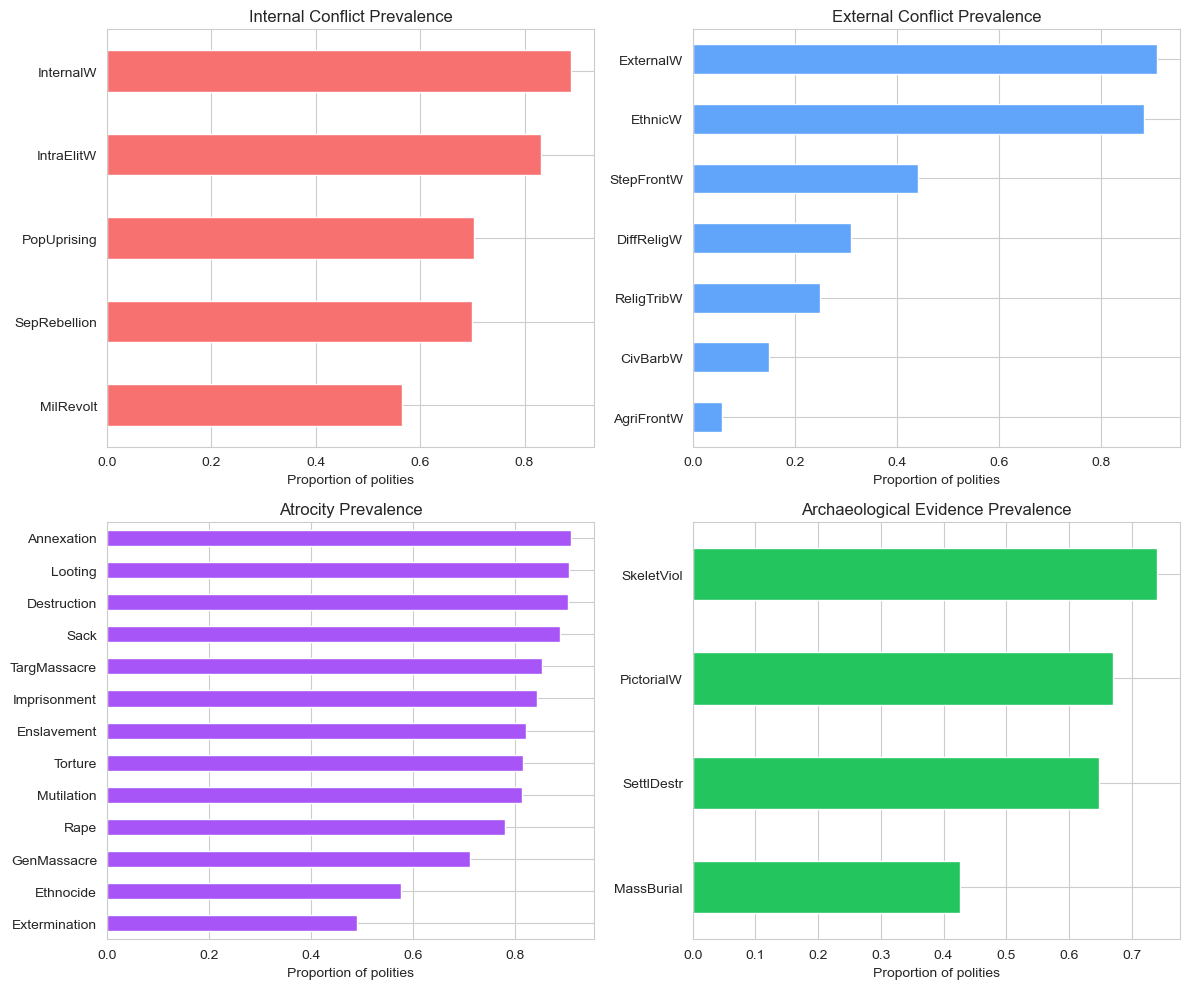

Most common internal: InternalW (88.9%)
Most common external: ExternalW (90.9%)
Most common atrocity: Annexation (90.9%)


In [56]:
# Distribution of violence variables (polity-level)
# - How common is each type of violence?
# - Are there era differences?
# - Correlation matrix of violence types

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Internal conflict (civil wars, uprisings, military revolts)
ax1 = axes[0, 0]
internal_means = violence_by_polity[INTERNAL_CONFLICT_VARS].mean().sort_values(ascending=True)
internal_means.plot(kind='barh', ax=ax1, color='#f87171')
ax1.set_title('Internal Conflict Prevalence')
ax1.set_xlabel('Proportion of polities')

# External conflict (ethnic, religious, frontier wars)
ax2 = axes[0, 1]
external_means = violence_by_polity[EXTERNAL_CONFLICT_VARS].mean().sort_values(ascending=True)
external_means.plot(kind='barh', ax=ax2, color='#60a5fa')
ax2.set_title('External Conflict Prevalence')
ax2.set_xlabel('Proportion of polities')

# Atrocities (torture, rape, enslavement, genocide, mass killings)
ax3 = axes[1, 0]
atrocity_means = violence_by_polity[ATROCITY_VARS].mean().sort_values(ascending=True)
atrocity_means.plot(kind='barh', ax=ax3, color='#a855f7')
ax3.set_title('Atrocity Prevalence')
ax3.set_xlabel('Proportion of polities')

# Archaeological evidence of violence
ax4 = axes[1, 1]
arch_means = violence_by_polity[ARCHAEOLOGICAL_VARS].mean().sort_values(ascending=True)
arch_means.plot(kind='barh', ax=ax4, color='#22c55e')
ax4.set_title('Archaeological Evidence Prevalence')
ax4.set_xlabel('Proportion of polities')

plt.tight_layout()
plt.savefig('figures/08_violence_prevalence.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Most common internal: {internal_means.idxmax()} ({internal_means.max():.1%})")
print(f"Most common external: {external_means.idxmax()} ({external_means.max():.1%})")
print(f"Most common atrocity: {atrocity_means.idxmax()} ({atrocity_means.max():.1%})")

Using 11 variables with >40% coverage


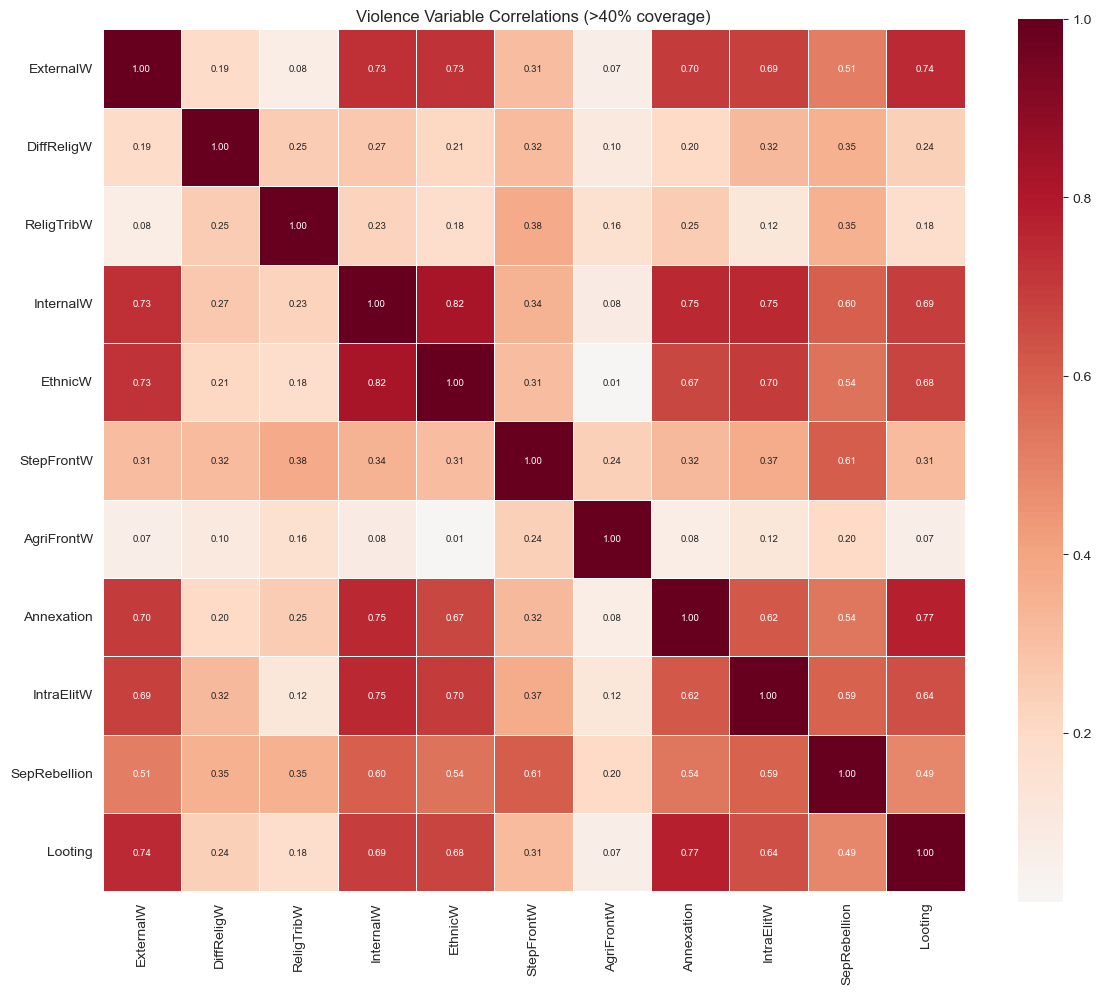


Top correlations:
  InternalW <-> EthnicW: 0.823
  Annexation <-> Looting: 0.774
  InternalW <-> IntraElitW: 0.752
  InternalW <-> Annexation: 0.749
  ExternalW <-> Looting: 0.744


In [57]:
# Correlation matrix of violence types
# Use higher-coverage variables only (>40%)
high_coverage_vars = coverage_df[coverage_df['Coverage'] > 40]['Variable'].tolist()
print(f"Using {len(high_coverage_vars)} variables with >40% coverage")

corr_matrix = violence_by_polity[high_coverage_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, annot_kws={'size': 7})
plt.title('Violence Variable Correlations (>40% coverage)')
plt.tight_layout()
plt.savefig('figures/08_violence_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

# Highest correlations
print("\nTop correlations:")
corr_pairs = []
for i, v1 in enumerate(high_coverage_vars):
    for v2 in high_coverage_vars[i+1:]:
        corr_pairs.append((v1, v2, corr_matrix.loc[v1, v2]))
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for v1, v2, corr in corr_pairs[:5]:
    print(f"  {v1} <-> {v2}: {corr:.3f}")

## 4. Violence and Duration Analysis

Test whether violence variables predict civilizational duration.

In [58]:
# Create composite violence indices
violence_by_polity['internal_score'] = violence_by_polity[INTERNAL_CONFLICT_VARS].mean(axis=1)
violence_by_polity['external_score'] = violence_by_polity[EXTERNAL_CONFLICT_VARS].mean(axis=1)
violence_by_polity['atrocity_score'] = violence_by_polity[ATROCITY_VARS].mean(axis=1)
violence_by_polity['total_violence'] = violence_by_polity[ALL_VIOLENCE_VARS].mean(axis=1)

# Add human sacrifice from AggrSCWarAgriRelig
violence_by_polity = violence_by_polity.join(hs_by_polity, how='left')

print("Composite scores:")
print(violence_by_polity[['internal_score', 'external_score', 'atrocity_score', 'total_violence', 'HS']].describe().round(3))

Composite scores:
       internal_score  external_score  atrocity_score  total_violence       HS
count         235.000         316.000         268.000         339.000  285.000
mean            0.797           0.520           0.849           0.650    0.312
std             0.317           0.310           0.273           0.312    0.455
min             0.000           0.000           0.000           0.000    0.000
25%             0.695           0.333           0.880           0.488    0.000
50%             0.975           0.500           0.967           0.733    0.000
75%             1.000           0.800           1.000           0.904    1.000
max             1.000           1.000           1.000           1.000    1.000


In [59]:
# Merge with modeling dataset
# Note: modeling_df['PolityName'] contains PolID codes, not human-readable names
modeling_indexed = modeling_df.set_index('PolityName')
combined_df = modeling_indexed.join(violence_by_polity[['internal_score', 'external_score', 
                                                         'atrocity_score', 'total_violence', 'HS']])
analysis_df = combined_df[combined_df['total_violence'].notna()].copy()
print(f"Analysis: {len(analysis_df)} polities with violence data")

# Correlations with duration
from scipy import stats
violence_features = ['internal_score', 'external_score', 'atrocity_score']

print("\n=== VIOLENCE vs DURATION ===")
for feat in violence_features + ['total_violence', 'HS']:
    valid = analysis_df[[feat, 'duration_years']].dropna()
    if len(valid) > 10:
        corr, pval = stats.pearsonr(valid[feat], valid['duration_years'])
        sig = '*' if pval < 0.05 else ''
        print(f"  {feat:18s}: r={corr:+.3f}, p={pval:.4f} {sig}")

# Multiple regression
X = analysis_df[violence_features].fillna(0)
y = analysis_df['duration_years']
reg = LinearRegression().fit(X, y)
r2 = r2_score(y, reg.predict(X))

print(f"\nRegression R²={r2:.3f}")
print("Coefficients (years per unit):")
for feat, coef in zip(violence_features, reg.coef_):
    print(f"  {feat}: {coef:+.0f}")

Analysis: 247 polities with violence data

=== VIOLENCE vs DURATION ===
  internal_score    : r=-0.263, p=0.0003 *
  external_score    : r=-0.121, p=0.0673 
  atrocity_score    : r=-0.443, p=0.0000 *
  total_violence    : r=-0.296, p=0.0000 *
  HS                : r=+0.060, p=0.3689 

Regression R²=0.179
Coefficients (years per unit):
  internal_score: -33
  external_score: -60
  atrocity_score: -199


In [60]:
# Classification: Does adding violence improve instability prediction?
# Using 184 years threshold (established in NB04) for consistency across analyses
# Note: this analysis uses 247/256 polities (9 lack violence data)
INSTABILITY_THRESHOLD = 184
analysis_df['unstable'] = (analysis_df['duration_years'] < INSTABILITY_THRESHOLD).astype(int)
print(f"Instability threshold: {INSTABILITY_THRESHOLD} years")
print(f"Unstable: {analysis_df['unstable'].sum()} / {len(analysis_df)}")

# Existing features from NB07 (note: lowercase column names)
exist_feats = [f for f in ['PC1_hier','PC2_hier','PC3_hier','total_warfare_tech','total_rel'] 
               if f in analysis_df.columns]
viol_feats = ['internal_score', 'external_score', 'atrocity_score']

X_existing = analysis_df[exist_feats].fillna(0)
X_with_violence = analysis_df[exist_feats + viol_feats].fillna(0)
y_class = analysis_df['unstable']

# Cross-validation comparison
cv_existing = cross_val_score(RandomForestClassifier(100, max_depth=5, random_state=42), 
                               X_existing, y_class, cv=5, scoring='roc_auc')
cv_violence = cross_val_score(RandomForestClassifier(100, max_depth=5, random_state=42), 
                               X_with_violence, y_class, cv=5, scoring='roc_auc')

print(f"\n=== CLASSIFICATION AUC ===")
print(f"Existing:   {cv_existing.mean():.3f} ± {cv_existing.std():.2f}")
print(f"+Violence:  {cv_violence.mean():.3f} ± {cv_violence.std():.2f}  ({cv_violence.mean()-cv_existing.mean():+.3f})")

# Feature importance
rf = RandomForestClassifier(100, max_depth=5, random_state=42).fit(X_with_violence, y_class)
imp = pd.DataFrame({'Feature': X_with_violence.columns, 'Importance': rf.feature_importances_})
print(f"\nFeature importance:")
print(imp.sort_values('Importance', ascending=False).to_string(index=False))

Instability threshold: 184 years
Unstable: 127 / 247

=== CLASSIFICATION AUC ===
Existing:   0.545 ± 0.11
+Violence:  0.512 ± 0.12  (-0.033)

Feature importance:
           Feature  Importance
          PC1_hier    0.191111
          PC3_hier    0.137514
          PC2_hier    0.132468
         total_rel    0.128777
total_warfare_tech    0.126010
    atrocity_score    0.111618
    external_score    0.091004
    internal_score    0.081498


## 5. Internal vs External Conflict

Hypothesis: Internal conflict (civil wars, uprisings) may be more destabilizing than external wars.

=== INTERNAL vs EXTERNAL CONFLICT ===
Internal: r=-0.263, p=0.0003, n=190
External: r=-0.121, p=0.0673, n=231


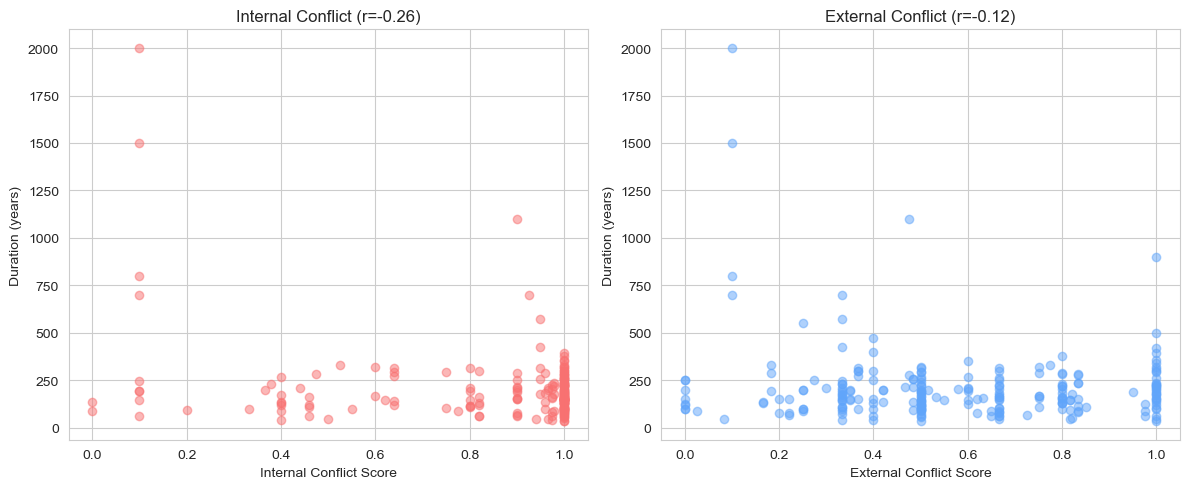

In [61]:
# Section 5: Internal vs External Conflict

# Direct comparison
int_valid = analysis_df[['internal_score', 'duration_years']].dropna()
ext_valid = analysis_df[['external_score', 'duration_years']].dropna()

int_corr, int_p = stats.pearsonr(int_valid['internal_score'], int_valid['duration_years'])
ext_corr, ext_p = stats.pearsonr(ext_valid['external_score'], ext_valid['duration_years'])

print("=== INTERNAL vs EXTERNAL CONFLICT ===")
print(f"Internal: r={int_corr:+.3f}, p={int_p:.4f}, n={len(int_valid)}")
print(f"External: r={ext_corr:+.3f}, p={ext_p:.4f}, n={len(ext_valid)}")

# Scatter comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(int_valid['internal_score'], int_valid['duration_years'], alpha=0.5, c='#f87171')
axes[0].set_xlabel('Internal Conflict Score')
axes[0].set_ylabel('Duration (years)')
axes[0].set_title(f'Internal Conflict (r={int_corr:.2f})')

axes[1].scatter(ext_valid['external_score'], ext_valid['duration_years'], alpha=0.5, c='#60a5fa')
axes[1].set_xlabel('External Conflict Score')
axes[1].set_ylabel('Duration (years)')
axes[1].set_title(f'External Conflict (r={ext_corr:.2f})')

plt.tight_layout()
plt.savefig('figures/08_internal_vs_external.png', dpi=150)
plt.show()

## 6. Atrocity Analysis

Do states that commit more atrocities have shorter durations?

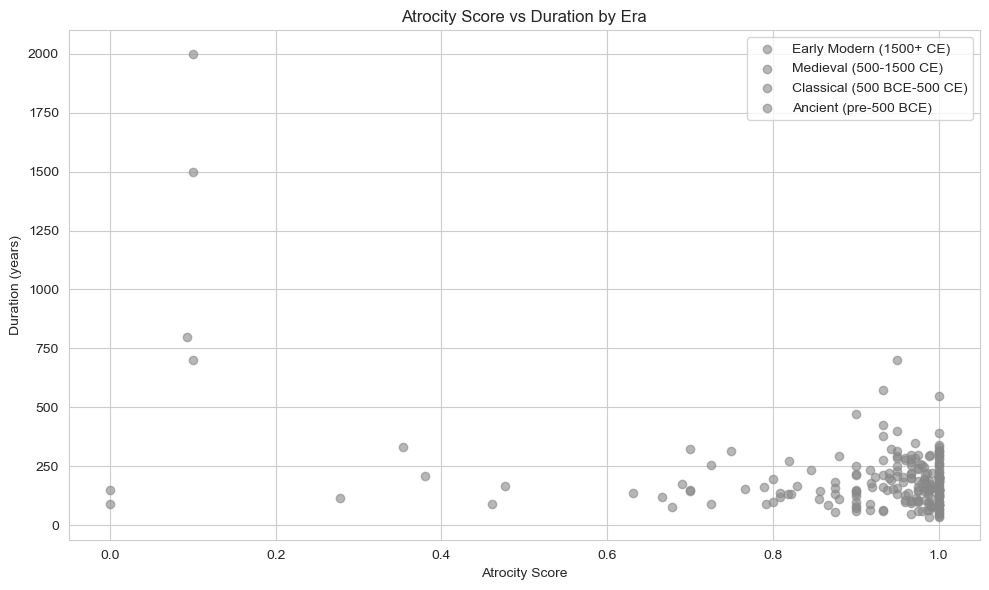

=== ATROCITY EFFECT BY ERA ===
  Ancient (pre-500 BCE): r=-0.635, p=0.000, n=45
  Classical (500 BCE-500 CE): r=-0.031, p=0.853, n=39
  Early Modern (1500+ CE): r=+0.173, p=0.286, n=40
  Medieval (500-1500 CE): r=+0.010, p=0.930, n=86

Atrocity-Warfare correlation: r=0.267


In [62]:
# Section 6: Atrocity Analysis

era_colors = {'Ancient': '#22c55e', 'Classical': '#60a5fa', 'Medieval': '#a855f7', 'Early Modern': '#f87171'}

plt.figure(figsize=(10, 6))
for era in analysis_df['era'].dropna().unique():
    mask = analysis_df['era'] == era
    plt.scatter(analysis_df.loc[mask, 'atrocity_score'], 
                analysis_df.loc[mask, 'duration_years'],
                label=era, alpha=0.6, c=era_colors.get(era, '#888'))

plt.xlabel('Atrocity Score')
plt.ylabel('Duration (years)')
plt.title('Atrocity Score vs Duration by Era')
plt.legend()
plt.tight_layout()
plt.savefig('figures/08_atrocity_vs_duration.png', dpi=150)
plt.show()

# Atrocity correlation by era
print("=== ATROCITY EFFECT BY ERA ===")
for era in sorted(analysis_df['era'].dropna().unique()):
    era_subset = analysis_df[analysis_df['era'] == era]
    valid = era_subset[['atrocity_score', 'duration_years']].dropna()
    if len(valid) > 10:
        r, p = stats.pearsonr(valid['atrocity_score'], valid['duration_years'])
        print(f"  {era:15s}: r={r:+.3f}, p={p:.3f}, n={len(valid)}")

# Atrocity-warfare correlation (potential confounder)
if 'total_warfare_tech' in analysis_df.columns:
    atr_war = analysis_df[['atrocity_score', 'total_warfare_tech']].dropna()
    r, _ = stats.pearsonr(atr_war['atrocity_score'], atr_war['total_warfare_tech'])
    print(f"\nAtrocity-Warfare correlation: r={r:.3f}")

## 7. Era-Stratified Analysis

Following the pattern from NB04-06: effects may vary by era.

                       Era  n  internal_score  external_score  atrocity_score  total_violence
     Ancient (pre-500 BCE) 69          -0.637          -0.073          -0.635          -0.209
Classical (500 BCE-500 CE) 43           0.107           0.158          -0.031           0.052
   Early Modern (1500+ CE) 43           0.048           0.207           0.173           0.249
    Medieval (500-1500 CE) 92           0.032           0.076           0.010           0.023


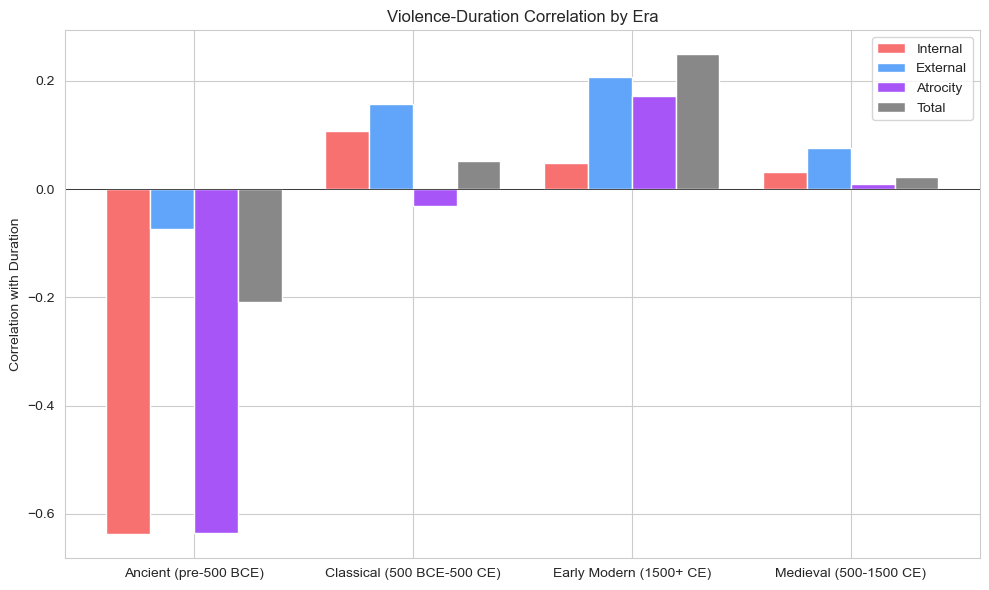

In [63]:
# Section 7: Era-Stratified Violence Effects

era_results = []
for era in sorted(analysis_df['era'].dropna().unique()):
    era_subset = analysis_df[analysis_df['era'] == era]
    results = {'Era': era, 'n': len(era_subset)}
    
    for feat in ['internal_score', 'external_score', 'atrocity_score', 'total_violence']:
        valid = era_subset[[feat, 'duration_years']].dropna()
        if len(valid) > 10:
            r, _ = stats.pearsonr(valid[feat], valid['duration_years'])
            results[feat] = round(r, 3)
        else:
            results[feat] = np.nan
    era_results.append(results)

era_corr_df = pd.DataFrame(era_results)
print(era_corr_df.to_string(index=False))

# Bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(era_corr_df))
width = 0.2

ax.bar(x - 1.5*width, era_corr_df['internal_score'], width, label='Internal', color='#f87171')
ax.bar(x - 0.5*width, era_corr_df['external_score'], width, label='External', color='#60a5fa')
ax.bar(x + 0.5*width, era_corr_df['atrocity_score'], width, label='Atrocity', color='#a855f7')
ax.bar(x + 1.5*width, era_corr_df['total_violence'], width, label='Total', color='#888')

ax.set_ylabel('Correlation with Duration')
ax.set_xticks(x)
ax.set_xticklabels(era_corr_df['Era'])
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.legend()
ax.set_title('Violence-Duration Correlation by Era')

plt.tight_layout()
plt.savefig('figures/08_violence_by_era.png', dpi=150)
plt.show()

## 8. Integration with Three-Mechanism Model

How does violence fit with complexity + warfare tech + religion?

In [ ]:
# Section 8: 4-Mechanism RF Comparison (NB07-style)

# Feature sets
complexity_feats = ['PC1_hier', 'PC2_hier', 'PC3_hier']
warfare_feats = ['total_warfare_tech']
religion_feats = ['total_rel']
violence_feats = ['internal_score', 'external_score', 'atrocity_score']

y = analysis_df['unstable']

# Model progression
print("=== MODEL PROGRESSION ===")
results = []
for name, feats in [
    ('1. Complexity', complexity_feats),
    ('2. + Warfare', complexity_feats + warfare_feats),
    ('3. + Religion (3-mech)', complexity_feats + warfare_feats + religion_feats),
    ('4. + Violence (4-mech)', complexity_feats + warfare_feats + religion_feats + violence_feats),
    ('5. Violence only', violence_feats)
]:
    X = analysis_df[feats].fillna(0)
    cv = cross_val_score(RandomForestClassifier(100, max_depth=5, random_state=42), X, y, cv=5, scoring='roc_auc')
    results.append({'Model': name, 'AUC': round(cv.mean(), 3), 'Std': round(cv.std(), 3)})
    print(f"  {name:<30} AUC={cv.mean():.3f} ± {cv.std():.3f}")

# Train/test split
X_4mech = analysis_df[complexity_feats + warfare_feats + religion_feats + violence_feats].fillna(0)
X_3mech = analysis_df[complexity_feats + warfare_feats + religion_feats].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X_4mech, y, test_size=0.2, random_state=42, stratify=y)

rf4 = RandomForestClassifier(100, max_depth=5, random_state=42).fit(X_train, y_train)
rf3 = RandomForestClassifier(100, max_depth=5, random_state=42).fit(X_train[complexity_feats + warfare_feats + religion_feats], y_train)

auc4 = roc_auc_score(y_test, rf4.predict_proba(X_test)[:, 1])
auc3 = roc_auc_score(y_test, rf3.predict_proba(X_test[complexity_feats + warfare_feats + religion_feats])[:, 1])

print(f"\n=== TEST SPLIT (80/20) ===")
print(f"  3-mechanism: {auc3:.3f}")
print(f"  4-mechanism: {auc4:.3f}")
print(f"  Difference:  {auc4 - auc3:+.3f}")

# Feature importance
rf_full = RandomForestClassifier(100, max_depth=5, random_state=42).fit(X_4mech, y)
imp_4 = pd.DataFrame({'Feature': X_4mech.columns, 'Importance': rf_full.feature_importances_})
imp_4 = imp_4.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(imp_4['Feature'], imp_4['Importance'], color='#60a5fa')
plt.xlabel('Importance')
plt.title('4-Mechanism Feature Importance')
plt.tight_layout()
plt.savefig('figures/08_four_mechanism_importance.png', dpi=150)
plt.show()

# Save results
pd.DataFrame(results).to_csv('models/violence_model_progression.csv', index=False)
print("\nSaved: models/violence_model_progression.csv")

## 9. Summary & Conclusions

Key findings from violence analysis.

In [65]:
# Section 9: Save Results to CSV

# 1. Violence coverage
coverage_df.to_csv('models/violence_coverage.csv', index=False)
print("Saved: models/violence_coverage.csv")

# 2. Violence-duration correlations
corr_results = []
for feat in ['internal_score', 'external_score', 'atrocity_score', 'total_violence', 'HS']:
    valid = analysis_df[[feat, 'duration_years']].dropna()
    if len(valid) > 10:
        r, p = stats.pearsonr(valid[feat], valid['duration_years'])
        corr_results.append({'Variable': feat, 'r': round(r, 4), 'p': round(p, 4), 'n': len(valid)})
violence_corr_df = pd.DataFrame(corr_results)
violence_corr_df.to_csv('models/violence_regression_results.csv', index=False)
print("Saved: models/violence_regression_results.csv")

# 3. Era-stratified results
era_corr_df.to_csv('models/violence_era_results.csv', index=False)
print("Saved: models/violence_era_results.csv")

# 4. Classification comparison
class_results = pd.DataFrame({
    'Model': ['3-mechanism', '4-mechanism (+violence)'],
    'AUC_mean': [round(cv_3.mean(), 4), round(cv_4.mean(), 4)],
    'AUC_std': [round(cv_3.std(), 4), round(cv_4.std(), 4)],
    'N': [len(analysis_df), len(analysis_df)]
})
class_results.to_csv('models/violence_classification_results.csv', index=False)
print("Saved: models/violence_classification_results.csv")

# 5. Feature importance (4-mechanism model)
imp_4.to_csv('models/violence_feature_importance.csv', index=False)
print("Saved: models/violence_feature_importance.csv")

print("\n=== SUMMARY ===")
print(f"Polities: {len(analysis_df)}/256")
print(f"Key finding: atrocity_score r={violence_corr_df[violence_corr_df['Variable']=='atrocity_score']['r'].values[0]}")
print(f"4-mech AUC: {cv_4.mean():.3f}")

Saved: models/violence_coverage.csv
Saved: models/violence_regression_results.csv
Saved: models/violence_era_results.csv
Saved: models/violence_classification_results.csv
Saved: models/violence_feature_importance.csv

=== SUMMARY ===
Polities: 247/256
Key finding: atrocity_score r=-0.4432
4-mech AUC: 0.512


## Limitations

- Violence variables may have more missing data than warfare tech
- Atrocities are recorded by victors/survivors - survivorship bias
- Causality unclear: does violence cause instability, or do unstable states become violent?
- Archaeological evidence biased toward visible/preserved violence